### Task 2: Multi-Objects Detection

**LOAD DATA** 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
data_path ='data/sample_1a2bc3012c9defca.npz'

# import `plot_map` function
from utils.plot import plot_map, plot_map_single

There are 24 agents and 91 timesteps in the this scenario. Each agents has one trajectory as the ground truth. Each trajectory can be represented as 10 properties: $[center_x, center_y, center_z, boundingbox_x, boundingbox_y, boundingbox_z, heading, vel_x, vel_y, valid]$

In [2]:
info = np.load(data_path, allow_pickle=True)
all_agent_trajs        = info['all_agent']    
all_agent_trajs.shape  #[24 agents, 91 timesteps the interval between each timestep is 0.1 second,\
    #10 denotes [center_x, center_y, center_z, boundingbox_x, boundingbox_y, boundingbox_z, heading, vel_x, vel_y, valid] ]
#the valid flag is either 0 or 1. 1 means the valid, 0 means invalid
obj_types              = info['object_type']
lane_polylines         = info['lane']           #  list of [n,7] array [x,y,z,ori_x,ori_y,ori_z,type]
road_polylines         = info['road_polylines'] #  list of [n,7] array [x,y,z,ori_x,ori_y,ori_z,type]
crosswalk_polylines    = info['crosswalk']      #  list of [n,7] array [x,y,z,ori_x,ori_y,ori_z,type]
speed_bump_polylines   = info['speed_bump']     #  list of [n,7] array [x,y,z,ori_x,ori_y,ori_z,type]
stop_signs_polylines   = info['stop_sign']      #  list of [n,7] array [x,y,z,ori_x,ori_y,ori_z,type]
drive_way_polylines    = info['drive_way']      #  list of [n,7] array [x,y,z,ori_x,ori_y,ori_z,type]

We select the 11th timestep as the current timestep 

In [3]:
all_agent_current = all_agent_trajs[:,10]
all_agent_current.shape

(24, 10)

In [4]:
# ground truth for the future 1s,2s,3s can be easily derived by :
predict_horizon = 20 #20,30
all_gt_future=all_agent_trajs[:,11:11+predict_horizon]
all_gt_future.shape

(24, 20, 10)

Index of target agent to predict

In [5]:
tracks        = info['predict_list']  
print(tracks)
agents_to_predict = all_agent_trajs[tracks]
agents_to_predict.shape

[22 15  4  5  9 14  6  7]


(8, 91, 10)

The homework should be done on these 8 agents.

**Q1.Using constant velocity model to predict the future (1s,2s,3s) trajectories of the target agent and calculate the ADE and FDE.**

+ ADE(Average Displacement Error) is the average L2 distance between the ground truth and the predicted positions over all time steps.
+ FDE(Final Displacement Error) is the L2 distance between the ground truth and the predicted positions at the final time step.

(8, 20)
average ADE:  0.5041634637241841
average FDE:  1.3812445671009477


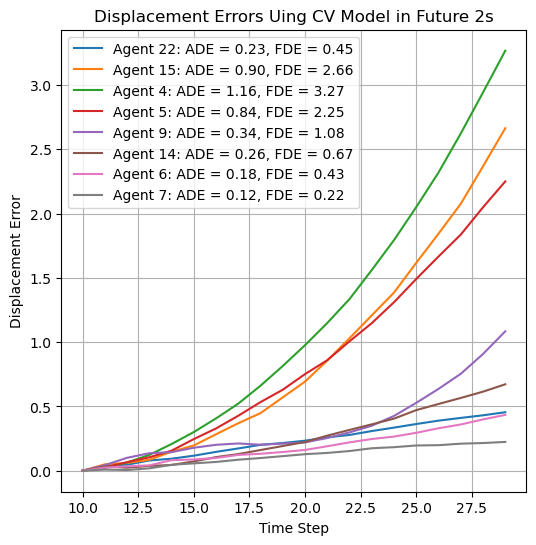

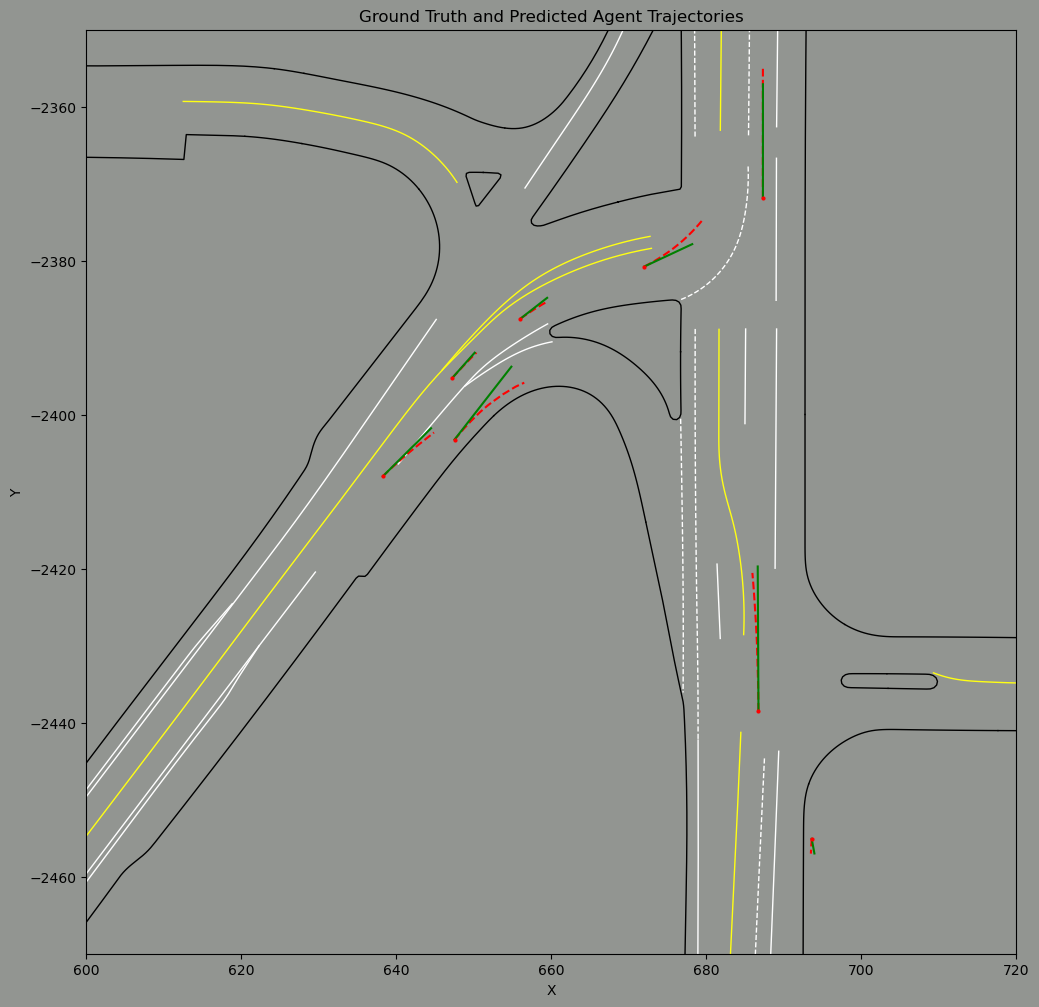

In [6]:
# Obtain the ground truth of position for the future 1/2/3s for the agents to predict
pos_gt = agents_to_predict[:, 11: 11+predict_horizon, 0:2]
const_vel = agents_to_predict[:, 11, 7:9]
pos_gt.shape, const_vel.shape

# predict the future 1s position using constant velocity model
pos_pred_cv = np.zeros((pos_gt.shape))
pos_pred_cv[:, 0, :] = agents_to_predict[:, 11, 0:2]
# print(pos_gt[:, 0, :])
# print(const_vel)
# print(pos_gt[:, 1, :])

for i in range(1, predict_horizon):
    pos_pred_cv[:, i, 0] += pos_pred_cv[:, 0, 0] + 0.1 * const_vel[:, 0] * i
    pos_pred_cv[:, i, 1] += pos_pred_cv[:, 0, 1] + 0.1 * const_vel[:, 1] * i

# Calculate the displacement errors
displacement_errors = np.linalg.norm(pos_gt - pos_pred_cv, axis=2)

# Calculate ADE
# print(displacement_errors)
print(displacement_errors.shape)
ADE = np.mean(displacement_errors, axis=1)
# print(ADE)

# Calculate FDE
FDE = displacement_errors[:, -1]
# print(FDE)

print("average ADE: ", np.mean(ADE))
print("average FDE: ", np.mean(FDE))

# Time Step
time_steps = np.arange(10, 10 + predict_horizon)

# Visualize the displacement errors
plt.figure(figsize=(6, 6))

for i in range(8):
    plt.plot(time_steps, displacement_errors[i, :], label='Agent {}: ADE = {:.2f}, FDE = {:.2f}'.format(tracks[i], ADE[i], FDE[i]))

plt.title("Displacement Errors Uing CV Model in Future {}s".format(int(predict_horizon/10)))
plt.xlabel('Time Step')
plt.ylabel('Displacement Error')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the map
ax = plot_map(road_polylines)

# Visualize the ground truth and predicted trajectories
for i in range(8):
    plt.plot(pos_gt[i, :, 0], pos_gt[i, :, 1], 'r--', label='Agent {} Ground Truth'.format(tracks[i]))
    plt.plot(pos_pred_cv[i, :, 0], pos_pred_cv[i, :, 1], 'g', label='Agent {} Predicted'.format(tracks[i]))
    plt.plot(pos_gt[i, 0, 0], pos_gt[i, 0, 1], 'ro', markersize=2)  # Initial point as a red circle

plt.title("Ground Truth and Predicted Agent Trajectories")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

**Q2.Using constant acceleration model to predict the future (1s,2s,3s) trajectories of the target agent and calculate the ADE and FDE.** 

(8, 20)
average ADE:  1.9089400268323165
average FDE:  5.502283840985841


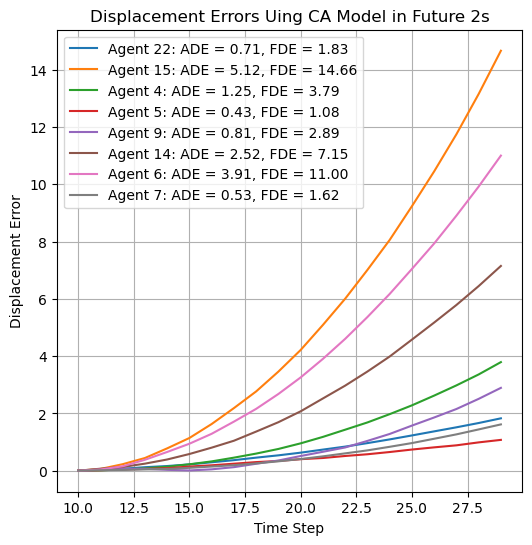

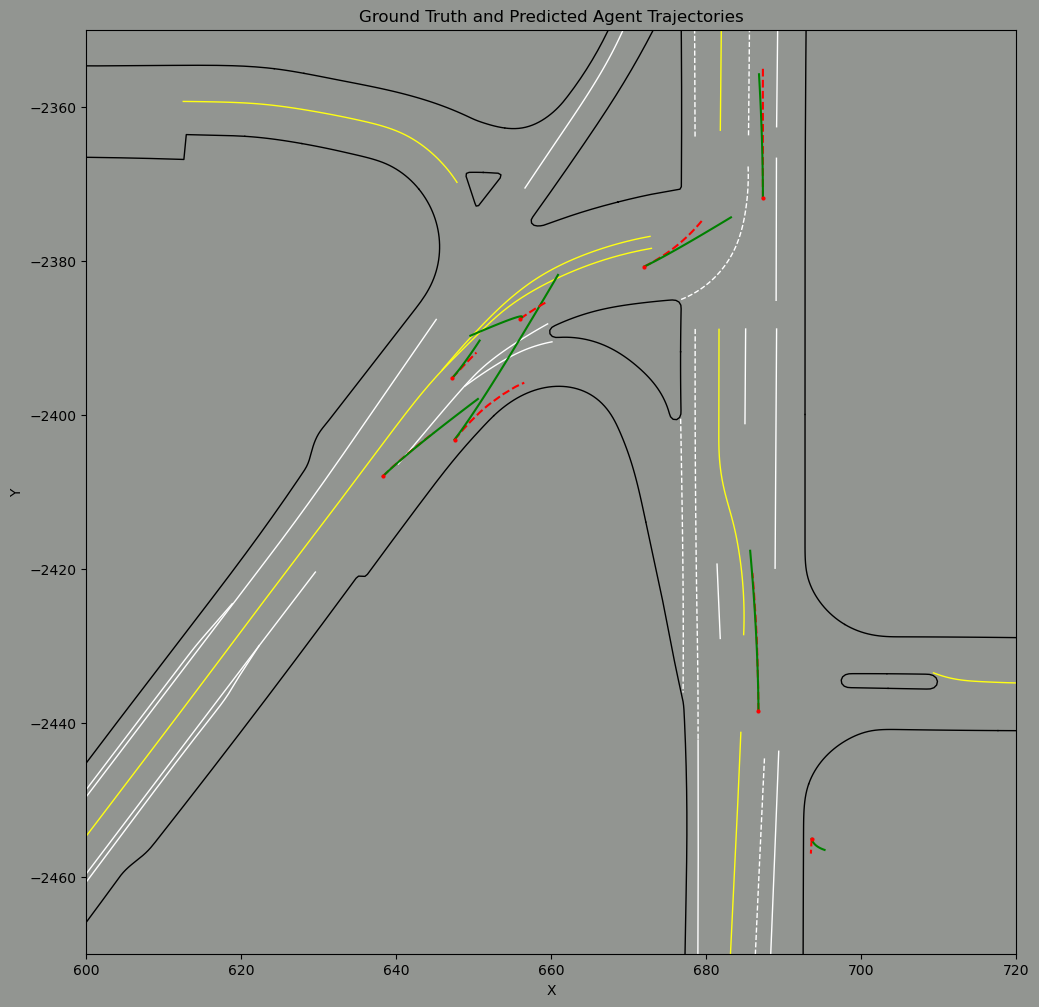

In [7]:
# Obtain the ground truth of position for the future 1/2/3s for the agents to predict
pos_gt = agents_to_predict[:, 11: 11+predict_horizon, 0:2]
const_acc = (agents_to_predict[:, 11, 7:9] - agents_to_predict[:, 10, 7:9]) / 0.1

# predict the future position using constant acceleration model
pos_pred_ca = np.zeros((pos_gt.shape))
pos_pred_ca[:, 0, :] = agents_to_predict[:, 11, 0:2]
vel_pred = np.zeros((pos_gt.shape))
vel_pred[:, 0, :] = agents_to_predict[:, 11, 7:9]

for i in range(1, predict_horizon):
    vel_pred[:, i, 0] += vel_pred[:, 0, 0] + const_acc[:, 0] * 0.1 * i
    vel_pred[:, i, 1] += vel_pred[:, 0, 1] + const_acc[:, 1] * 0.1 * i
    pos_pred_ca[:, i, 0] += pos_pred_ca[:, i - 1, 0] + 0.1 * vel_pred[:, i, 0]
    pos_pred_ca[:, i, 1] += pos_pred_ca[:, i - 1, 1] + 0.1 * vel_pred[:, i, 1]

# Calculate the displacement errors
displacement_errors = np.linalg.norm(pos_gt - pos_pred_ca, axis=2)

# Calculate ADE
# print(displacement_errors)
print(displacement_errors.shape)
ADE = np.mean(displacement_errors, axis=1)
# print(ADE)

# Calculate FDE
FDE = displacement_errors[:, -1]
# print(FDE)

print("average ADE: ", np.mean(ADE))
print("average FDE: ", np.mean(FDE))

# Time Step
time_steps = np.arange(10, 10 + predict_horizon)

# Visualize the displacement errors
plt.figure(figsize=(6, 6))

for i in range(8):
    plt.plot(time_steps, displacement_errors[i, :], label='Agent {}: ADE = {:.2f}, FDE = {:.2f}'.format(tracks[i], ADE[i], FDE[i]))

plt.title("Displacement Errors Uing CA Model in Future {}s".format(int(predict_horizon/10)))
plt.xlabel('Time Step')
plt.ylabel('Displacement Error')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the map
ax = plot_map(road_polylines)

# Visualize the ground truth and predicted trajectories
for i in range(8):
    plt.plot(pos_gt[i, :, 0], pos_gt[i, :, 1], 'r--', label='Agent {} Ground Truth'.format(tracks[i]))
    plt.plot(pos_pred_ca[i, :, 0], pos_pred_ca[i, :, 1], 'g', label='Agent {} Predicted'.format(tracks[i]))
    plt.plot(pos_gt[i, 0, 0], pos_gt[i, 0, 1], 'ro', markersize=2)  # Initial point as a red circle

plt.title("Ground Truth and Predicted Agent Trajectories")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

**Using Constant Turn Rate and Velocity(CTRV) model to predict the future (1s,2s,3s) trajectories of the target agent and calculate the ADE and FDE.**

[4.6855593  0.8798077  0.40763095 1.5747588  1.5799342  0.7850889
 0.63873935 0.8395734 ]
[4.6699257  0.8745613  0.42222592 1.5755498  1.5800648  0.7825035
 0.62687707 0.83649266]
[4.654292   0.8693149  0.4368209  1.5763409  1.5801953  0.7799181
 0.6150148  0.83341193]
[4.6386585  0.8640685  0.45141587 1.577132   1.5803258  0.77733266
 0.6031525  0.8303312 ]
[4.623025   0.8588221  0.46601084 1.577923   1.5804564  0.77474725
 0.59129024 0.8272505 ]
[4.6073914  0.8535757  0.4806058  1.5787141  1.5805869  0.77216184
 0.57942796 0.82416975]
[4.591758   0.8483293  0.49520078 1.5795052  1.5807174  0.76957643
 0.5675657  0.821089  ]
[4.576124  0.8430829 0.5097958 1.5802963 1.580848  0.766991  0.5557034
 0.8180083]
[4.5604906 0.8378365 0.5243907 1.5810874 1.5809785 0.7644056 0.5438411
 0.8149276]
[4.544857   0.8325901  0.5389857  1.5818784  1.581109   0.7618202
 0.53197885 0.81184685]
[4.5292234  0.8273437  0.55358064 1.5826695  1.5812396  0.7592348
 0.52011657 0.8087661 ]
[4.51359   0.8220973

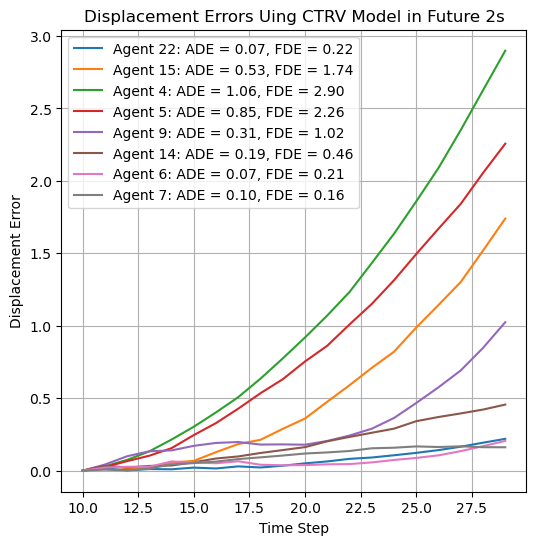

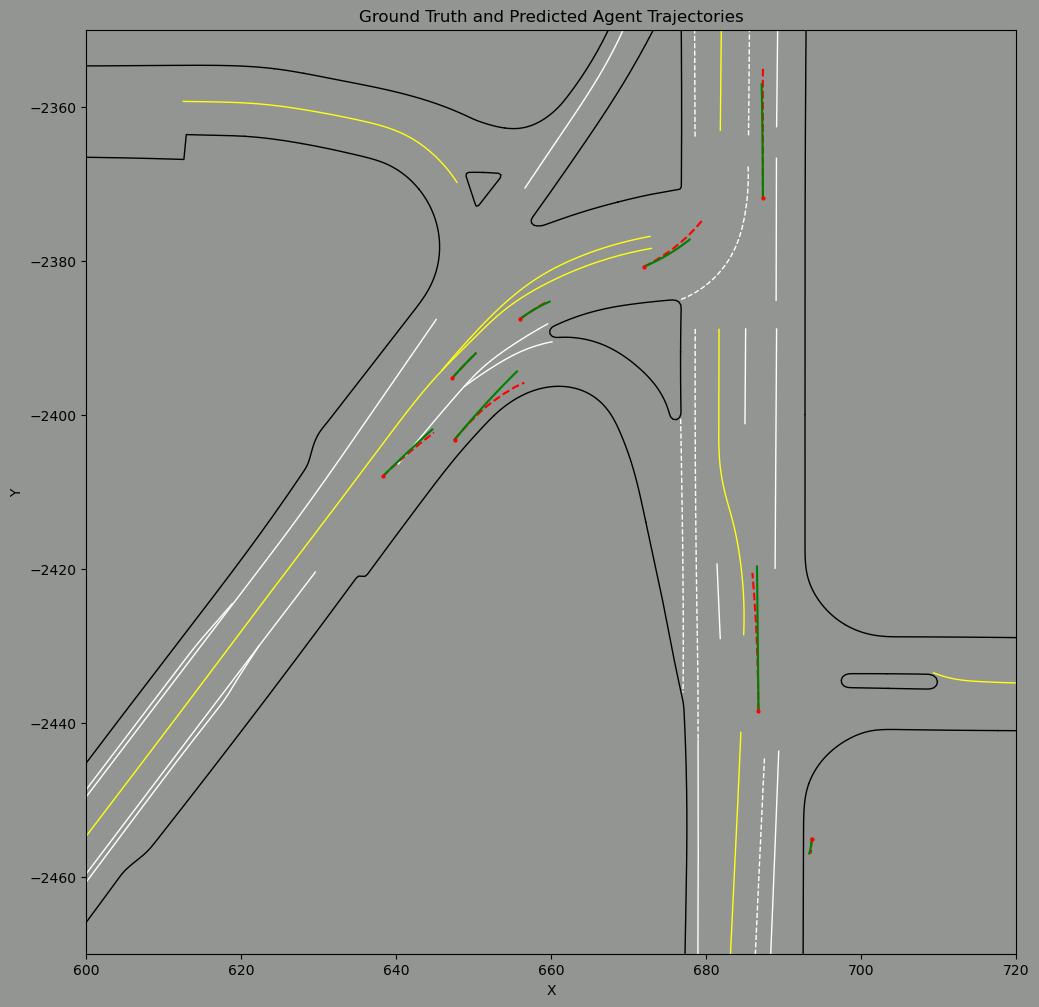

In [8]:
# Obtain the ground truth of position for the future 1/2/3s for the agents to predict
pos_gt = agents_to_predict[:, 11: 11+predict_horizon, 0:2]
const_vel = agents_to_predict[:, 11, 7:9]
const_V = np.sqrt(const_vel[:, 0] ** 2 + const_vel[:, 1] ** 2)
# print(const_vel.shape)
init_yaw = agents_to_predict[:, 11, 6]
const_yawd = (agents_to_predict[:, 11, 6] - agents_to_predict[:, 10, 6]) / 0.1

# predict the future 1s position using constant velocity model
pos_pred_ctrv = np.zeros((pos_gt.shape))
pos_pred_ctrv[:, 0, :] = agents_to_predict[:, 11, 0:2]

for i in range(1, predict_horizon):
    current_yaw = init_yaw + const_yawd * i * 0.1
    print(current_yaw)
    pos_pred_ctrv[:, i, 0] += pos_pred_ctrv[:, i - 1, 0] + 0.1 * const_V * np.cos(current_yaw)
    pos_pred_ctrv[:, i, 1] += pos_pred_ctrv[:, i - 1, 1] + 0.1 * const_V * np.sin(current_yaw)

# Calculate the displacement errors
displacement_errors = np.linalg.norm(pos_gt - pos_pred_ctrv, axis=2)

# Calculate ADE
# print(displacement_errors)
# print(displacement_errors.shape)
ADE = np.mean(displacement_errors, axis=1)
# print(ADE)

# Calculate FDE
FDE = displacement_errors[:, -1]
# print(FDE)

print("average ADE: ", np.mean(ADE))
print("average FDE: ", np.mean(FDE))

# Time Step
time_steps = np.arange(10, 10 + predict_horizon)

# Visualize the displacement errors
plt.figure(figsize=(6, 6))

for i in range(8):
    plt.plot(time_steps, displacement_errors[i, :], label='Agent {}: ADE = {:.2f}, FDE = {:.2f}'.format(tracks[i], ADE[i], FDE[i]))

plt.title("Displacement Errors Uing CTRV Model in Future {}s".format(int(predict_horizon/10)))
plt.xlabel('Time Step')
plt.ylabel('Displacement Error')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the map
ax = plot_map(road_polylines)

# Visualize the ground truth and predicted trajectories
for i in range(8):
    plt.plot(pos_gt[i, :, 0], pos_gt[i, :, 1], 'r--', label='Agent {} Ground Truth'.format(tracks[i]))
    plt.plot(pos_pred_ctrv[i, :, 0], pos_pred_ctrv[i, :, 1], 'g', label='Agent {} Predicted'.format(tracks[i]))
    plt.plot(pos_gt[i, 0, 0], pos_gt[i, 0, 1], 'ro', markersize=2)  # Initial point as a red circle

plt.title("Ground Truth and Predicted Agent Trajectories")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Briefly discuss the observations from your results. 

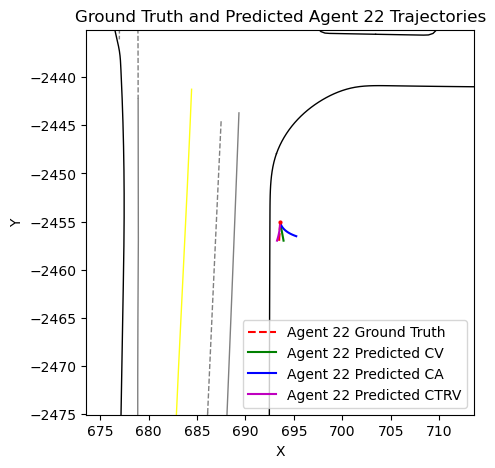

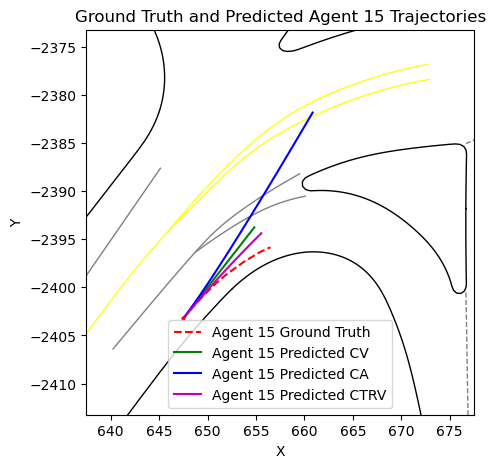

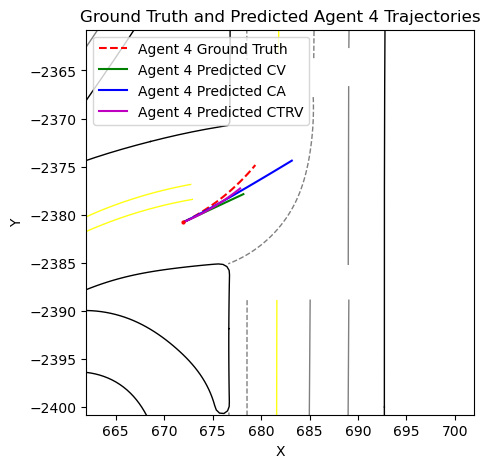

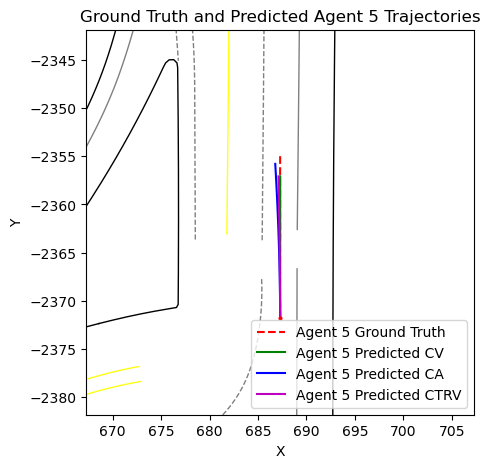

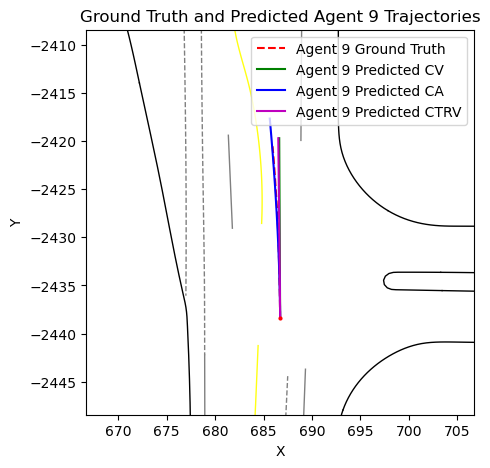

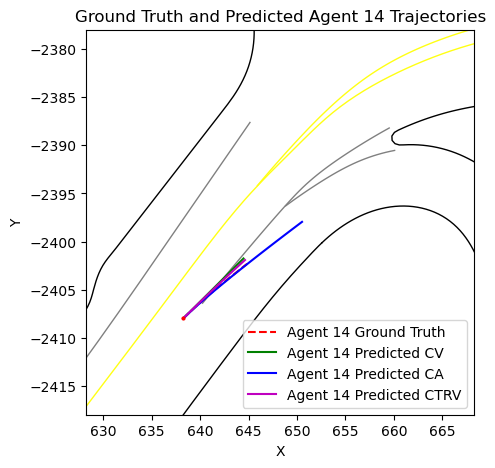

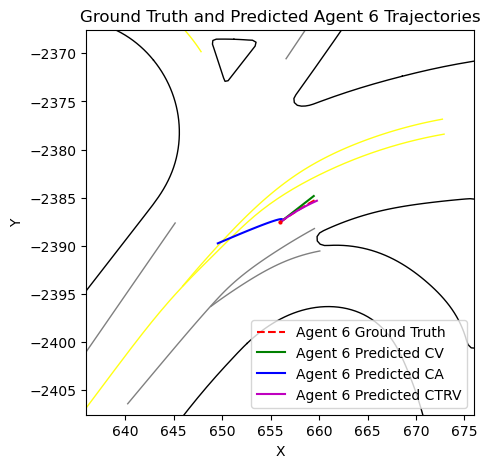

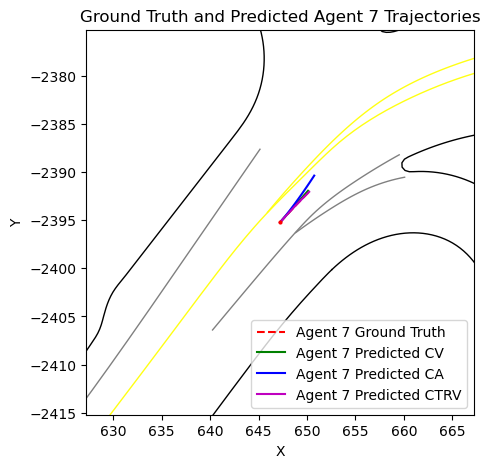

In [9]:
# # Visualize the map
# ax = plot_map(road_polylines)

# # Visualize the ground truth and predicted trajectories
# for i in range(8):
#     plt.plot(pos_gt[i, :, 0], pos_gt[i, :, 1], 'r--')
#     plt.plot(pos_pred_ctrv[i, :, 0], pos_pred_cv[i, :, 1], 'g')
#     plt.plot(pos_pred_ctrv[i, :, 0], pos_pred_ca[i, :, 1], 'g')
#     plt.plot(pos_pred_ctrv[i, :, 0], pos_pred_ctrv[i, :, 1], 'g')
#     plt.plot(pos_gt[i, 0, 0], pos_gt[i, 0, 1], 'ro', markersize=2)  # Initial point as a red circle

# plt.title("Ground Truth and Predicted Agent Trajectories")
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

regions = [
    [-20 + pos_gt[0, 0, 0], 20 + pos_gt[0, 0, 0], -20 + pos_gt[0, 0, 1], 20 + pos_gt[0, 0, 1]],
    [-10 + pos_gt[1, 0, 0], 30 + pos_gt[1, 0, 0], -10 + pos_gt[1, 0, 1], 30 + pos_gt[1, 0, 1]],
    [-10 + pos_gt[2, 0, 0], 30 + pos_gt[2, 0, 0], -20 + pos_gt[2, 0, 1], 20 + pos_gt[2, 0, 1]],
    [-20 + pos_gt[3, 0, 0], 20 + pos_gt[3, 0, 0], -10 + pos_gt[3, 0, 1], 30 + pos_gt[3, 0, 1]],
    [-20 + pos_gt[4, 0, 0], 20 + pos_gt[4, 0, 0], -10 + pos_gt[4, 0, 1], 30 + pos_gt[4, 0, 1]],
    [-10 + pos_gt[5, 0, 0], 30 + pos_gt[5, 0, 0], -10 + pos_gt[5, 0, 1], 30 + pos_gt[5, 0, 1]],
    [-20 + pos_gt[6, 0, 0], 20 + pos_gt[6, 0, 0], -20 + pos_gt[6, 0, 1], 20 + pos_gt[6, 0, 1]],
    [-20 + pos_gt[7, 0, 0], 20 + pos_gt[7, 0, 0], -20 + pos_gt[7, 0, 1], 20 + pos_gt[7, 0, 1]]
]

for i in range(8):
    ax = plot_map_single(road_polylines, regions[i])
    plt.plot(pos_gt[i, :, 0], pos_gt[i, :, 1], 'r--', label='Agent {} Ground Truth'.format(tracks[i]))
    plt.plot(pos_pred_cv[i, :, 0], pos_pred_cv[i, :, 1], 'g', label='Agent {} Predicted CV'.format(tracks[i]))
    plt.plot(pos_pred_ca[i, :, 0], pos_pred_ca[i, :, 1], 'b', label='Agent {} Predicted CA'.format(tracks[i]))
    plt.plot(pos_pred_ctrv[i, :, 0], pos_pred_ctrv[i, :, 1], 'm', label='Agent {} Predicted CTRV'.format(tracks[i]))
    plt.plot(pos_gt[i, 0, 0], pos_gt[i, 0, 1], 'ro', markersize=2)  # Initial point as a red circle
    plt.title('Ground Truth and Predicted Agent {} Trajectories'.format(tracks[i]))
    # plt.grid()
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

If you want to visualize the scenario here are some simple demo codes for you.

    'TYPE_FREEWAY': 1,
    'TYPE_SURFACE_STREET': 2,
    'TYPE_BIKE_LANE': 3,

    # for roadline
    'TYPE_UNKNOWN': -1,
    'TYPE_BROKEN_SINGLE_WHITE': 6,
    'TYPE_SOLID_SINGLE_WHITE': 7,
    'TYPE_SOLID_DOUBLE_WHITE': 8,
    'TYPE_BROKEN_SINGLE_YELLOW': 9,
    'TYPE_BROKEN_DOUBLE_YELLOW': 10,
    'TYPE_SOLID_SINGLE_YELLOW': 11,
    'TYPE_SOLID_DOUBLE_YELLOW': 12,
    'TYPE_PASSING_DOUBLE_YELLOW': 13,

    # for roadedge
    'TYPE_ROAD_EDGE_BOUNDARY': 15,
    'TYPE_ROAD_EDGE_MEDIAN': 16,

    # for stopsign
    'TYPE_STOP_SIGN': 17,

    # for crosswalk
    'TYPE_CROSSWALK': 18,

    # for speed bump
    'TYPE_SPEED_BUMP': 19,
    
    # for driveway
    'TYPE_DRIVEWAY': 20,

In [10]:
# fig.set_facecolor('xkcd:grey') 
# ax.set_facecolor('xkcd:grey')
# for polyline in road_polylines:
#     map_type = polyline[0,6]
#     if map_type == 6:
#         plt.plot(polyline[:, 0], polyline[:, 1], 'w', linestyle='dashed', linewidth=1)
#     elif map_type == 7:
#         plt.plot(polyline[:, 0], polyline[:, 1], 'w', linestyle='solid', linewidth=1)
#     elif map_type == 8:
#         plt.plot(polyline[:, 0], polyline[:, 1], 'w', linestyle='solid', linewidth=1)
#     elif map_type == 9:
#         plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='dashed', linewidth=1)
#     elif map_type == 10:
#         plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='dashed', linewidth=1)
#     elif map_type == 11:
#         plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='solid', linewidth=1)
#     elif map_type == 12:
#         plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='solid', linewidth=1)
#     elif map_type == 13:
#         plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='dotted', linewidth=1)
#     elif map_type == 15:
#         plt.plot(polyline[:, 0], polyline[:, 1], 'k', linewidth=1)
#     elif map_type == 16:
#         plt.plot(polyline[:, 0], polyline[:, 1], 'k', linewidth=1)

# ax.axis([-70+ sdc_current_state[0], 70+ sdc_current_state[0], -70+ sdc_current_state[1], 70 + sdc_current_state[1]])

# # draw the agent's current position

# filename = './viz.png' 
# plt.savefig(filename)       
# plt.close()
# plt.show()